In [1]:
from fastai.vision.all import *
from fastaudio.core.all import *

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [3]:
aud2spec = AudioToSpec.from_cfg(AudioConfig.Voice(f_min=0., n_mels=128))
spec = aud2spec(AudioTensor.create(
Path("../大丈夫な.mp3")))
spec.shape

torch.Size([1, 128, 415])

<AxesSubplot:>

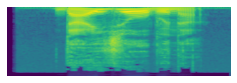

In [4]:
show_image(spec)

In [5]:
spec.shape

torch.Size([1, 128, 415])

In [7]:
conv_1 = nn.Conv1d(128, 256, 11, 2)
conv_2 = nn.Conv1d(128, 128, 29, dilation=2, groups=128)
x = conv_1(spec)
conv_2(spec).shape

torch.Size([1, 128, 359])

In [8]:
conv_1.weight.shape

torch.Size([256, 128, 11])

<AxesSubplot:>

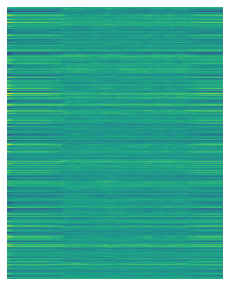

In [9]:
show_image(conv_1(spec))

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
sep_conv = nn.Sequential(nn.Conv1d(128, 128, 11, 2, groups=128),
nn.Conv1d(128, 256, 1, 1))

In [12]:
conv_1(spec).shape, sep_conv(spec).shape

(torch.Size([1, 256, 203]), torch.Size([1, 256, 203]))

In [13]:
count_parameters(conv_1), count_parameters(sep_conv)

(360704, 34560)

In [14]:
class oldJasperSubblock(Module):
    r"A basic building sub-block of Jasper"
    
    def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
        self.conv = nn.Conv1d(in_channels, out_channels, kernel, stride, (kernel-1)//2, **kwargs)
        self.norm = nn.BatchNorm1d(out_channels)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(drop)
        
    def forward(self, x, res = 0):
        x = self.conv(x)
        x = self.norm(x)
        if not isinstance(res, int): x += res
        x = self.act(x)
        return self.drop(x)
    
    
class JasperSubblock(Module):
    r"A basic building sub-block of Jasper with QuartzNet separable convolutions"
    
    def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
        self.conv = nn.Sequential(nn.Conv1d(in_channels, in_channels, kernel, stride, (kernel-1)//2, groups=in_channels, **kwargs),
                                 nn.Conv1d(in_channels, out_channels, 1, 1))
        self.norm = nn.BatchNorm1d(out_channels)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(drop)
        
    def forward(self, x, res = 0):
        x = self.conv(x)
        x = self.norm(x)
        if not isinstance(res, int): x += res
        x = self.act(x)
        return self.drop(x)
    
class JasperBlock(Module):
    
    def __init__(self, in_channels, out_channels, kernel, num_subblocks=3, drop = 0.2):
        self.subblocks = nn.Sequential(*[JasperSubblock(in_channels, out_channels, kernel, 1, drop = 0.2)] \
        + [JasperSubblock(out_channels, out_channels, kernel, 1, drop = 0.2) for i in range(num_subblocks-2)])
        self.res_subblock = JasperSubblock(out_channels, out_channels, kernel, 1, drop = 0.2)
        self.res_conv = nn.Conv1d(in_channels, out_channels, 1)
        self.res_norm = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        x, res = self.subblocks(x), self.res_conv(x)
        x = self.res_subblock(x, self.res_norm(x))
        return x
    
class Jasper(Module):
    
    def __init__(self, n_mels, n_vocab, num_blocks_factor=1, num_subblocks = 3):
        KERNELS = [11, 13, 17, 21, 25]
        OUTS = [256, 384, 512, 640, 768, 256]
        DROPS = [0.2]*3 + [0.3]*2
        
        self.model = nn.Sequential(*[oldJasperSubblock(n_mels, 256, 11, 2)] \
        + [JasperBlock(OUTS[i-1], OUTS[i], KERNELS[i], num_subblocks, DROPS[i])
           for i in range(5) for _ in range(num_blocks_factor)] \
        + [oldJasperSubblock(OUTS[-2], 896, 29, 1, 0.4, dilation=2)],
          oldJasperSubblock(896, 1024, 1, 1, 0.4), nn.Conv1d(1024, n_vocab, 1), nn.Softmax(1)
        )
        
    def forward(self, x):
        return self.model(x)

confirming Softmaxex correctly

In [19]:
Jasper(128, 60)(spec)[0,:,0].sum()

AudioSpectrogram(1., grad_fn=<AliasBackward>)

107905468 parameters without separable convolutions

In [241]:
sum(p.numel() for p in Jasper(128, 60).parameters() if p.requires_grad)

26785724

In [100]:
spec.shape,Subblock(128, 256, 17, 1)(spec).shape

(torch.Size([1, 128, 95]), torch.Size([1, 256, 95]))

In [16]:
model = Jasper(128, 61)

In [17]:
out = model(spec)

In [24]:
out.shape

torch.Size([1, 61, 180])

In [20]:
F.ctc_loss(out, torch.randint(1, 61, (1, 10)))

TypeError: ctc_loss() missing 2 required positional arguments: 'input_lengths' and 'target_lengths'

In [25]:
# Target are to be padded
T = 180      # Input sequence length
C = 61      # Number of classes (including blank)
N = 1      # Batch size
S = 30      # Target sequence length of longest target in batch (padding length)
S_min = 10  # Minimum target length, for demonstration purposes
# Initialize random batch of input vectors, for *size = (T,N,C)
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
# Initialize random batch of targets (0 = blank, 1:C = classes)
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
ctc_loss = nn.CTCLoss()
loss = ctc_loss(input, target, input_lengths, target_lengths)
loss

In [34]:
target_lengths

tensor([21])

In [42]:
input.shape

torch.Size([180, 1, 61])

In [47]:
ctc_loss(out.reshape((180,1,61)), target, input_lengths, target_lengths)

AudioSpectrogram(-4.9218, grad_fn=<AliasBackward>)

# TODO:
- [ ] Figure out what to do with the length requirement:
- [ ] Use own implementation of CTC?
- [ ] Ignore actual lengths of seqs?
- [ ] Think through the proper way to encode lengths with padding?